# **Point Net - Classification**

In this notebook, we will use the classification version of point net to classify objects from the shapenet dataset

In [1]:
import os
import sys
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn.functional import kl_div


import open3d as o3


import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, fps, global_max_pool, radius
from torch_geometric.nn.conv import PointConv

#from open3d.web_visualizer import draw # for non Colab
#sys.path.append('../../PointNet-VAE/src')
sys.path.append('../src')

from models.utils import PointsTo3DShape
from models.PointNetEncoder import PointNetBackbone
from utils.calculate_loss import ChamferDistanceLoss
from models.PointCloudEncoder import PointCloudEncoder
from models.PointCloudDecoder import PointCloudDecoder, PointCloudDecoderSelf, PointCloudDecoderMLP
from models.AutoEncoder import AutoEncoder
from models.VAE import VAE
from data.dataset import DataModelNet
from utils.utils import *
from evaluation.evaluate import Evaluater


from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
print('MPS is build: {}'.format(torch.backends.mps.is_built()))
print('MPS Availability: {}'.format(torch.backends.mps.is_available()))
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps'
print('Device is set to :{}'.format(DEVICE))
#torch.set_default_device(DEVICE)
torch.seed = 42

MPS is build: True
MPS Availability: True
Device is set to :mps


### Get the data

In [4]:
# General parameters
#NUM_TRAIN_POINTS = 8192
NUM_TEST_POINTS = 1024

NUM_POINTS = 1024
NUM_CLASSES = 16

# model hyperparameters
GLOBAL_FEATS = 1024
BATCH_SIZE = 32

EPOCHS = 1000
LR = 0.0001
REG_WEIGHT = 0.001 

LATENT_DIM = 128

Helpers for our dataset

In [5]:
# get class - label mappings
CATEGORIES = {
    'Bathtub': 0,
    'Bed': 1,
    'Chair': 2,
    'Desk': 3,
    'Dresser': 4,
    'Monitor': 5,
    'Night_Stand': 6,
    'Sofa': 7,
    'Table': 8,
    'Toilet': 9,
}


In [6]:
data = DataModelNet(
        data_path = "../../data/ModelNet10" ,
        pre_transform = T.NormalizeScale(),
        train_batch_size = 32,
        val_batch_size = 32,
        train_num_points = 1024,
        val_num_points = 1024,
)

In [7]:
data.setup()
train_loader = data.train_dataloader()
val_loader = data.val_dataloader()

In [8]:
points = next(iter(train_loader))[0].pos
PointsTo3DShape(points)
    

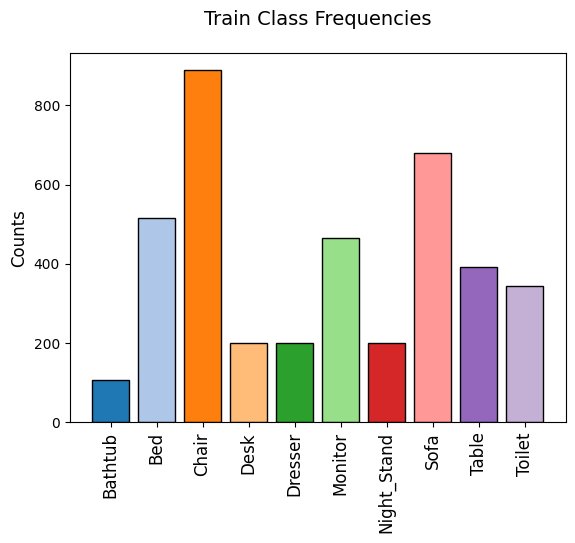

In [9]:
total_train_targets = []
for loader in train_loader:
    pos = loader.pos
    targets = loader.y
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)

class_bins = np.bincount(total_train_targets)

plt.bar(list(CATEGORIES.keys()), class_bins, 
             color=mpl.cm.tab20(np.arange(0, NUM_CLASSES)),
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Train Class Frequencies', size=14, pad=20);

In [10]:
encoder = PointCloudEncoder(latent_dim=LATENT_DIM, num_point=NUM_POINTS).to(DEVICE)
#encoder = PointNetBackbone(num_points=NUM_POINTS, num_global_feats=LATENT_DIM, local_feat=False).to(DEVICE)
decoder = PointCloudDecoderMLP(latent_dim=LATENT_DIM, num_hidden=3, num_point=NUM_POINTS).to(DEVICE)
autoencoder = AutoEncoder(encoder, decoder, device=DEVICE, latent_dim=LATENT_DIM).to(DEVICE)
vae = VAE(encoder, decoder, device=DEVICE, latent_dim=LATENT_DIM).to(DEVICE)

In [ ]:
#MODEL_PATH = '../../pointnet_transferlearning/models/trained/vae_pointnet_runs/vae_conv_run_best/run5/cls_model_804_0.06466853033219065.pth'
#vae.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
#vae.train()

In [ ]:
from utils.train import Trainer

model_run = Trainer(
        model=vae,
        criterion=ChamferDistanceLoss(),
        optimizer=optim.Adam(vae.parameters(), lr=0.001),
        encoder_type='ConvolutionEncoder',
        model_type='VAE',
        checkpoint='../models/checkpoints',
        experiment='trial',
        device='mps',
        kl_loss_weight = 0.00001)

In [ ]:

model_run.fit(train_loader, val_loader, 1000)

# END OF TRAINING CYCLE

In [32]:
model_evaluate = Evaluater(
        model=vae,
        criterion=ChamferDistanceLoss(),
        encoder_type='ConvolutionEncoder',
        model_type='VAE',
        checkpoint='../models/checkpoints/trial/checkpoint_499.pth',
        device='mps',
        )

In [33]:
points, reconstructed_x = model_evaluate.evaluate_data(next(iter(val_loader)))

Loss: 98.3421859741211 - Reconst Loss: 0.06096144765615463 - KL Loss: 98.2812271118164


In [44]:
N=20
PointsTo3DShape(points[N].squeeze().cpu())


In [45]:
PointsTo3DShape(reconstructed_x[N].cpu())


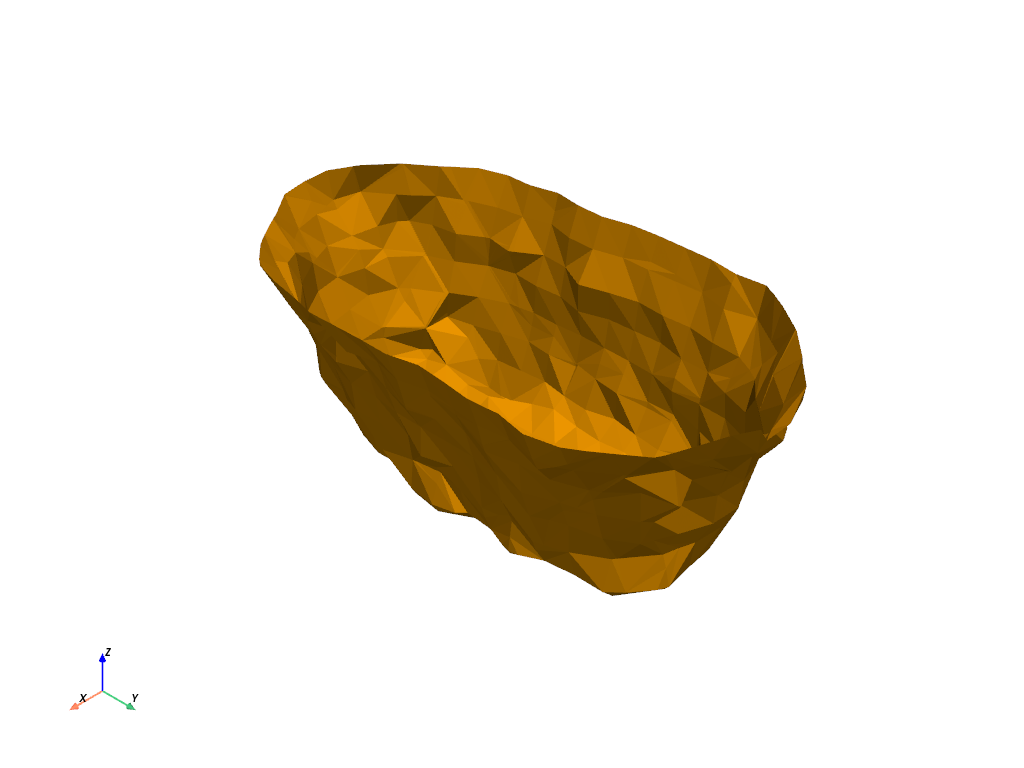

In [46]:
import pyvista as pv
point_cloud = pv.PolyData(reconstructed_x[N].cpu().numpy())
mesh = point_cloud.reconstruct_surface()
mesh.plot(color='orange')
